**Names: Philipp Köhler, Alexander Bespalov**


# Sheet 5

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## 1 Bayes: Signal or Noise?
To find the posterior probability we can use Bayes' theorem:

$$
p(\text { gamma ray } \mid \text { target direction })=\frac{p(\text { target direction } \mid \text { gamma ray }) p(\text { gamma ray })}{p(\text { target direction })}
$$

whereas:
$$
p(\text { target direction })=p(\text { target direction } \mid \text { gamma ray }) p(\text { gamma ray })+p(\text { target direction } \mid \text { background }) p(\text { background })
$$

Plugging in all the numbers from the exercise yields:
$$
p(\text { gamma ray } \mid \text { target direction }) =\frac{0.95 \cdot 0.1}{0.1 \cdot 0.9 + 0.95 \cdot 0.1} = \frac{19}{37} \approx 0.5135
$$

## 2 Bayes Classifier
The Bayes classifier is given by:
$$
\argmin_f R(f)
$$
$R(f)$ is the bayes risk.
$$
R(f) = \mathbb{E}_X\mathbb{E}_{Y \mid X}L(Y=y,f(X=x))
$$
The minimization can be done pointwise for each x. Therefore the function of interest is:
$$
\sum_{y\in Y}L(y,f(x))p(y \mid x)
$$
### (a)
For $\hat y=0$ the expected loss is:
$$
\mathbb{E}_{Y \mid X=x}L(y, 0)= 0 \cdot p(0\mid x) + 10 \cdot p(1 \mid x) = 10 \cdot p(1 \mid x)
$$
For $\hat y=1$ the expected loss is:
$$
\mathbb{E}_{Y \mid X=x}L(y, 1)= 0 \cdot p(1\mid x) + 1 \cdot p(0 \mid x) = 1 \cdot p(0 \mid x) = 1 - p(1 \mid x)
$$
To minimize the Loss, we want:
$$
10 \cdot p(y = 1 \mid x) < 1 - p(y = 1 \mid x).
$$

Rearrange this inequality:
$$
10 \cdot p(y = 1 \mid x) + p(y = 1 \mid x) < 1,
$$
$$
11 \cdot p(y = 1 \mid x) < 1,
$$
$$
p(y = 1 \mid x) < \frac{1}{11}.
$$

Therefore, the optimal Bayes classifier is:
$$
\hat{y} = 
\begin{cases} 
0 & \text{if } p(y = 1 \mid x) < \frac{1}{11}, \\
1 & \text{if } p(y = 1 \mid x) \geq \frac{1}{11}.
\end{cases}
$$
This classifier is more conservative about predicting $y=0$. This is useful when a misclassification of a true $y=1$ has disadvantages, as in the detection of illnesses.

## (b)

For $\hat y=0$ the expected loss is:
$$
\mathbb{E}_{Y \mid X=x}L(y, 0)= \sum_{i=1}^{k}  \alpha \cdot p(y=i\mid x) = \alpha
$$
For $\hat y = j, j \in \{1,2,...,k\}$ the expected loss is:
$$
\mathbb{E}_{Y \mid X=x}L(y, \hat y)= \sum_{i \in \{1,2,...,k\}\backslash j} 1 \cdot p(y=i \mid x) = 1-p(\hat y = j\mid x)
$$
The decision follows as:
$$
\hat{y} = 
\begin{cases} 
j & \text{if } 1 - p(y = j \mid x) < \alpha \text{ and } p(y = j \mid x) = \max\limits_{i \in \{1, \ldots, k\}} p(y = i \mid x), \\
0 & \text{if } 1 - \max\limits_{i \in \{1, \ldots, k\}} p(y = i \mid x) \geq \alpha.
\end{cases}
$$

$\alpha$ introduces a minimum certainty level for classes, else they are rejected. If the certainty is achieved the $y$ with the maximum probability is chosen. This is again important if misclassification causes trouble and a certainty level is needed.

## 3 QDA
### (a) + (b)

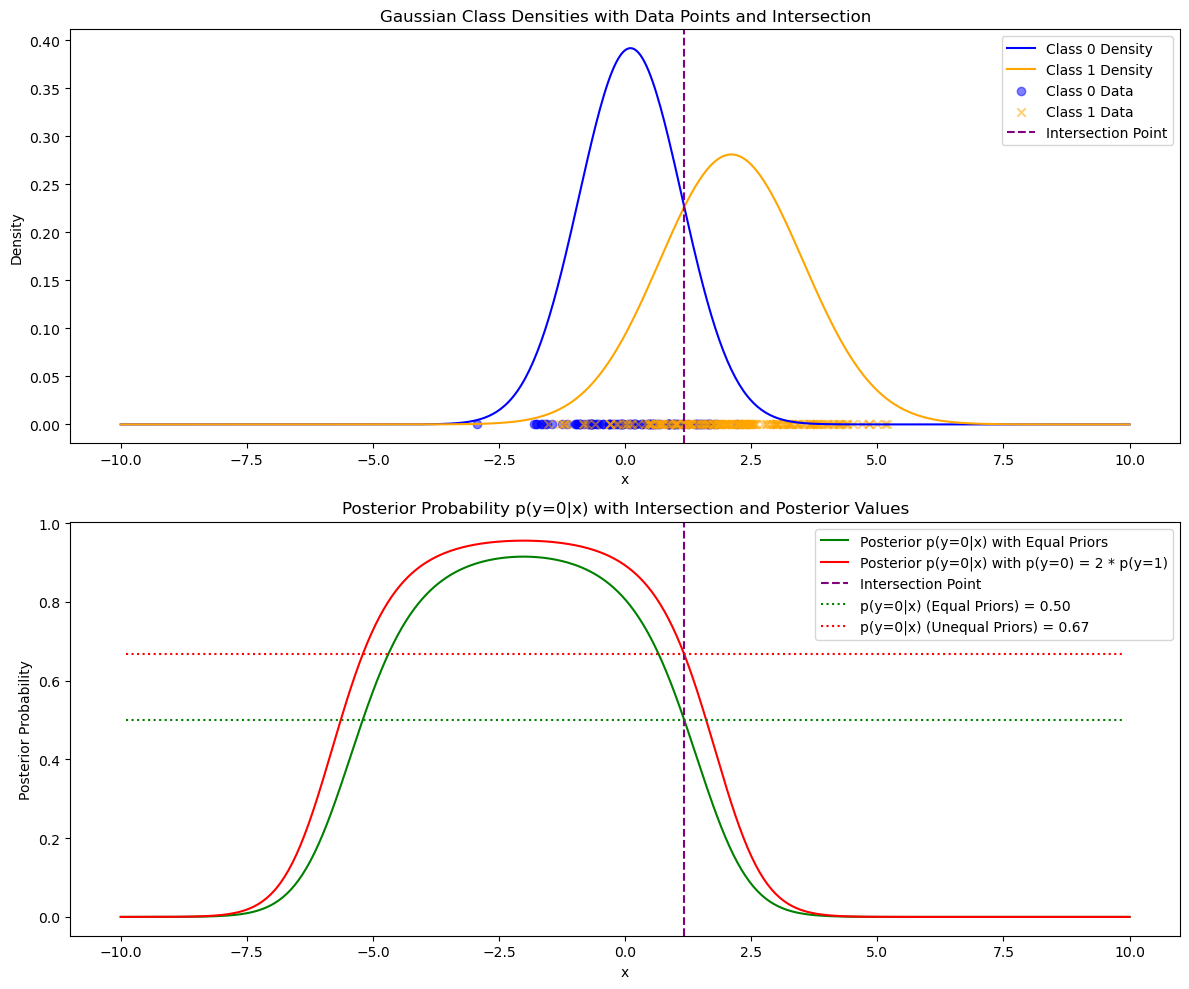

In [2]:
# Load data
pts = np.load('data/data1d.npy')
labels = np.load('data/labels1d.npy')

# Fit Gaussian distribution
class_0_pts = pts[labels == 0]
class_1_pts = pts[labels == 1]

mean_0, std_0 = np.mean(class_0_pts), np.std(class_0_pts)
mean_1, std_1 = np.mean(class_1_pts), np.std(class_1_pts)


x_range = np.linspace(-10, 10, 500)

# Compute Gaussian class densities
pdf_class_0 = norm.pdf(x_range, mean_0, std_0)
pdf_class_1 = norm.pdf(x_range, mean_1, std_1)

#find density intersections
def find_intersection():
    return fsolve(lambda x: norm.pdf(x, mean_0, std_0) - norm.pdf(x, mean_1, std_1), 1.0)[0]  # initial guess near expected value


x_intersect = find_intersection()
y_intersect_density = norm.pdf(x_intersect, mean_0, std_0)

# Assuming equal prior
prior_0_equal = 0.5
prior_1_equal = 0.5

# Compute posterior probabilities
posterior_y0_equal = (pdf_class_0 * prior_0_equal) / (pdf_class_0 * prior_0_equal + pdf_class_1 * prior_1_equal)

# Assuming unequal priors
prior_0_unequal = 2 / 3
prior_1_unequal = 1 / 3

# Compute posterior probabilities
posterior_y0_unequal = (pdf_class_0 * prior_0_unequal) / (pdf_class_0 * prior_0_unequal + pdf_class_1 * prior_1_unequal)

# Compute the posterior probabilities at the intersection point
y_intersect_posterior_equal = (norm.pdf(x_intersect, mean_0, std_0) * prior_0_equal) / \
                              (norm.pdf(x_intersect, mean_0, std_0) * prior_0_equal + norm.pdf(x_intersect, mean_1, std_1) * prior_1_equal)
y_intersect_posterior_unequal = (norm.pdf(x_intersect, mean_0, std_0) * prior_0_unequal) / \
                                (norm.pdf(x_intersect, mean_0, std_0) * prior_0_unequal + norm.pdf(x_intersect, mean_1, std_1) * prior_1_unequal)


plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(x_range, pdf_class_0, label="Class 0 Density", color="blue")
plt.plot(x_range, pdf_class_1, label="Class 1 Density", color="orange")
plt.scatter(class_0_pts, np.zeros_like(class_0_pts), label="Class 0 Data", color="blue", alpha=0.5, marker='o')
plt.scatter(class_1_pts, np.zeros_like(class_1_pts), label="Class 1 Data", color="orange", alpha=0.5, marker='x')
plt.axvline(x=x_intersect, color="purple", linestyle="--", label="Intersection Point")
plt.title("Gaussian Class Densities with Data Points and Intersection")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x_range, posterior_y0_equal, label="Posterior p(y=0|x) with Equal Priors", color="green")
plt.plot(x_range, posterior_y0_unequal, label="Posterior p(y=0|x) with p(y=0) = 2 * p(y=1)", color="red")
plt.axvline(x=x_intersect, color="purple", linestyle="--", label="Intersection Point")
plt.axhline(y=y_intersect_posterior_equal, color="green", linestyle=":", 
            label=f"p(y=0|x) (Equal Priors) = {y_intersect_posterior_equal:.2f}", xmin=0.05, xmax=0.95)
plt.axhline(y=y_intersect_posterior_unequal, color="red", linestyle=":", 
            label=f"p(y=0|x) (Unequal Priors) = {y_intersect_posterior_unequal:.2f}", xmin=0.05, xmax=0.95)
plt.title("Posterior Probability p(y=0|x) with Intersection and Posterior Values")
plt.xlabel("x")
plt.ylabel("Posterior Probability")
plt.legend()

plt.tight_layout()
plt.show()



We can see, that for a point at the intersection of the two class densities, meaning where they have equal value, the point is assigned a posterior probability of 0.5 to be in class 0, which makes sense as the probability for it to be in one class or the other should be equal as the priors are equal. If we now make the priors not equal in favor of class 0 the posterior also becomes larger for the point to be in class 0, as it can be seen in the graph. Mathmatically:
Given two classes $y=0$ and $y=1$, the posterior probability for $y=0$ is computed as follows:

$$
p(y=0 \mid x)=\frac{p(x \mid y=0) \cdot p(y=0)}{p(x \mid y=0) \cdot p(y=0)+p(x \mid y=1) \cdot p(y=1)}
$$


Similarly, the posterior probability for $y=1$ is:

$$
p(y=1 \mid x)=\frac{p(x \mid y=1) \cdot p(y=1)}{p(x \mid y=0) \cdot p(y=0)+p(x \mid y=1) \cdot p(y=1)}
$$


Since $p(y=0 \mid x)+p(y=1 \mid x)=1$, these probabilities are complementary. At the intersection point $x=x_{\text {intersect }}$, we have:

$$
p(x \mid y=0)=p(x \mid y=1)
$$


We denote this common density value at the intersection point as $D$, so:

$$
p\left(x_{\text {intersect }} \mid y=0\right)=p\left(x_{\text {intersect }} \mid y=1\right)=D
$$
When the priors are equal, i.e., $p(y=0)=p(y=1)=0.5$, the posterior probability for $y=0$ at the intersection point becomes:

$$
p\left(y=0 \mid x_{\text {intersect }}\right)=\frac{D \cdot 0.5}{D \cdot 0.5+D \cdot 0.5}=\frac{0.5}{0.5+0.5}=\frac{0.5}{1}=0.5
$$


Similarly,

$$
p\left(y=1 \mid x_{\text {intersect }}\right)=0.5
$$
Making the priors unequal, favoring class 0 . Suppose $p(y=0)=\frac{2}{3}$ and $p(y=1)=\frac{1}{3}$. Then, at $x_{\text {intersect, }}$, the posterior probability for $y=0$ becomes:

$$
p\left(y=0 \mid x_{\text {intersect }}\right)=\frac{D \cdot \frac{2}{3}}{D \cdot \frac{2}{3}+D \cdot \frac{1}{3}}=\frac{\frac{2}{3}}{\frac{2}{3}+\frac{1}{3}}=\frac{\frac{2}{3}}{1}=\frac{2}{3}
$$


Similarly, for class 1:

$$
p\left(y=1 \mid x_{\text {intersect }}\right)=\frac{D \cdot \frac{1}{3}}{D \cdot \frac{2}{3}+D \cdot \frac{1}{3}}=\frac{\frac{1}{3}}{1}=\frac{1}{3}
$$


## 4 Trees and Random Forests

### (a)

In [16]:
def misclassification_error(node):
    p_max = np.max(node)/np.sum(node)
    error = 1 - p_max
    return error

def gini_impurity(node):
    p = node/np.sum(node)
    gini = 1 - np.sum(p**2)
    return gini

def entropy(node):
    eps = 1e-10
    p = node/np.sum(node)
    entropy = -np.sum(p * np.log2(p+eps))
    return entropy

def uncertainty_reduction(node_1, node_2, metric_1, metric_2, parent_metric):
    num_points = np.sum(np.stack((node_1,node_2)))
    return parent_metric - (sum(node_1) / num_points) * metric_1 - (sum(node_2) / num_points) * metric_2

# data 
parent_node = [400,400]

split_A_node_1 = [300, 100]  
split_A_node_2 = [100, 300] 

split_B_node_1 = [200, 0]    
split_B_node_2 = [200, 400] 

# parent node metrics
misclass_parent = misclassification_error(parent_node)
gini_parent = gini_impurity(parent_node)
entropy_parent = entropy(parent_node)

# split A
misclass_A_1 = misclassification_error(split_A_node_1)
misclass_A_2 = misclassification_error(split_A_node_2)
gini_A_1 = gini_impurity(split_A_node_1)
gini_A_2 = gini_impurity(split_A_node_2)
entropy_A_1 = entropy(split_A_node_1)
entropy_A_2 = entropy(split_A_node_2)

misclass_A = uncertainty_reduction(split_A_node_1, split_A_node_2, misclass_A_1, misclass_A_2, misclass_parent)
gini_A = uncertainty_reduction(split_A_node_1, split_A_node_2, gini_A_1, gini_A_2, gini_parent)
entropy_A = uncertainty_reduction(split_A_node_1, split_A_node_2, entropy_A_1, entropy_A_2, entropy_parent)

#split B
misclass_B_1 = misclassification_error(split_B_node_1)
misclass_B_2 = misclassification_error(split_B_node_2)
gini_B_1 = gini_impurity(split_B_node_1)
gini_B_2 = gini_impurity(split_B_node_2)
entropy_B_1 = entropy(split_B_node_1)
entropy_B_2 = entropy(split_B_node_2)

misclass_B = uncertainty_reduction(split_B_node_1, split_B_node_2, misclass_B_1, misclass_B_2, misclass_parent)
gini_B = uncertainty_reduction(split_B_node_1, split_B_node_2, gini_B_1, gini_B_2, gini_parent)
entropy_B = uncertainty_reduction(split_B_node_1, split_B_node_2, entropy_B_1, entropy_B_2, entropy_parent)


print("Results for Split A:")
print(f"Misclassification Error Reduction: {misclass_A:.4f}")
print(f"Gini Impurity Reduction: {gini_A:.4f}")
print(f"Entropy Reduction: {entropy_A:.4f}")

print("\nResults for Split B:")
print(f"Misclassification Error Reduction: {misclass_B:.4f}")
print(f"Gini Impurity Reduction: {gini_B:.4f}")
print(f"Entropy Reduction: {entropy_B:.4f}")

if misclass_A > misclass_B:
    print("\nMisclassification Error prefers Split A")
else:
    print("\nMisclassification Error prefers Split B")

if gini_A > gini_B:
    print("Gini Impurity prefers Split A")
else:
    print("Gini Impurity prefers Split B")

if entropy_A > entropy_B:
    print("Entropy prefers Split A")
else:
    print("Entropy prefers Split B")

Results for Split A:
Misclassification Error Reduction: 0.2500
Gini Impurity Reduction: 0.1250
Entropy Reduction: 0.1887

Results for Split B:
Misclassification Error Reduction: 0.2500
Gini Impurity Reduction: 0.1667
Entropy Reduction: 0.3113

Misclassification Error prefers Split B
Gini Impurity prefers Split B
Entropy prefers Split B


The missclassification error is for both splits the same. Therefore, it does not prefer any of the splits.

### (b)

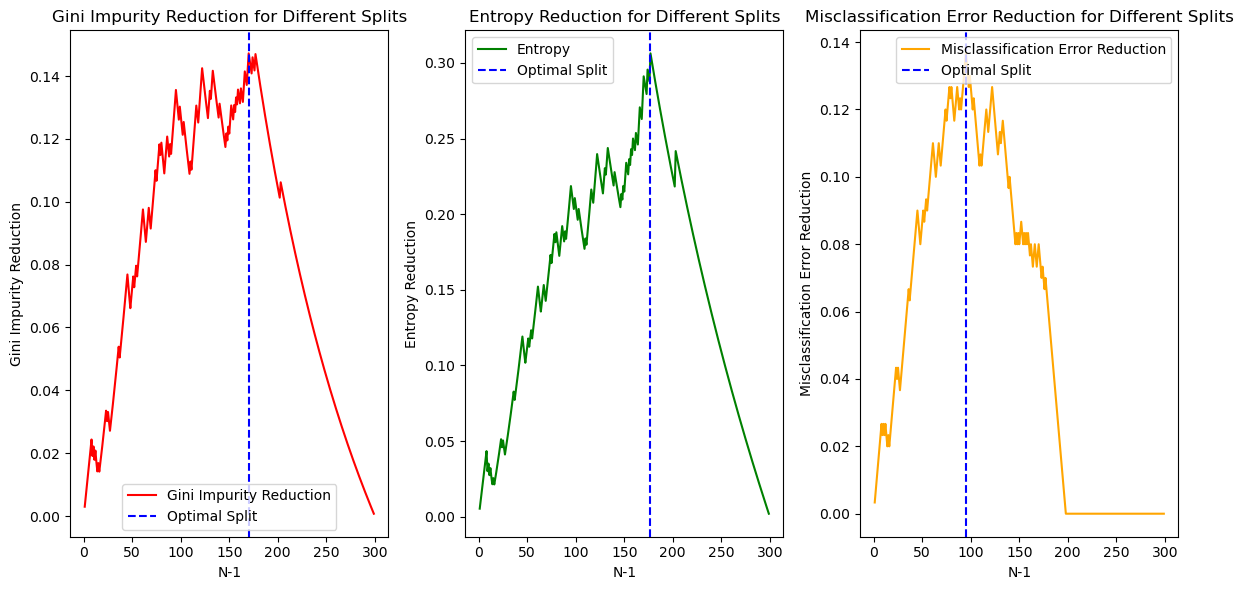

Optimal split according to Gini Impurity Reduction: 170
Optimal split according to Entropy Reduction: 177
Optimal split according to Misclassification Error Reduction: 95


In [17]:
# load the data
pts = np.load('data/data1d.npy')
labels = np.load('data/labels1d.npy')

# TODO: Sort the points to easily split them
sorted_indices = np.argsort(pts)
pts_sorted = pts[sorted_indices]
labels_sorted = labels[sorted_indices]

# TODO: Implement or find implementation for Gini impurity, entropy and misclassifcation error
def gini_impurity(probabilities):
    return 1 - np.sum(probabilities ** 2)

def entropy(probabilities):
    return -np.sum(probabilities * np.log2(probabilities))

def misclassification_error(probabilities):
    return 1 - np.max(probabilities)

def probabilities(partition):
    # divide counts by size of dataset to get cluster probabilites
    return np.unique(partition, return_counts=True)[1] / len(partition)

def compute_split_measure(l, l0, l1, method):
    p0 = probabilities(l0)
    p1 = probabilities(l1)
    p = probabilities(l)
    return method(p) - (len(l0) * method(p0) + len(l1) * method(p1)) / (len(l))

# TODO: Iterate over the possible splits, evaulating and saving the three criteria for each one
gini_impurities = []
entropies = []
misclassification_errors = []

for i in range(1, len(pts)):
    
    # Create the two partitions
    l0 = labels_sorted[:i] 
    l1 = labels_sorted[i:]  

    gini_impurity_value = compute_split_measure(labels_sorted, l0, l1, gini_impurity)
    entropy_value = compute_split_measure(labels_sorted, l0, l1, entropy)
    misclassification_error_value = compute_split_measure(labels_sorted, l0, l1, misclassification_error)
    
    gini_impurities.append(gini_impurity_value)
    entropies.append(entropy_value)
    misclassification_errors.append(misclassification_error_value)


# TODO: Then, Compute the split that each criterion favours and visualize them 
#       (e.g. with a histogram for each class and vertical lines to show the splits)
plt.figure(figsize=(12, 6))

# Plot the Gini impurity
plt.subplot(131)
plt.plot(range(1, len(pts)), gini_impurities, label='Gini Impurity Reduction', color='red')
plt.xlabel('N-1')
plt.ylabel('Gini Impurity Reduction')
plt.title('Gini Impurity Reduction for Different Splits')
plt.axvline(np.argmax(gini_impurities) + 1, color='blue', linestyle='--', label='Optimal Split')
plt.legend()

# Plot the Entropy
plt.subplot(132)
plt.plot(range(1, len(pts)), entropies, label='Entropy', color='green')
plt.xlabel('N-1')
plt.ylabel('Entropy Reduction')
plt.title('Entropy Reduction for Different Splits')
plt.axvline(np.argmax(entropies) + 1, color='blue', linestyle='--', label='Optimal Split')
plt.legend()

# Plot the Misclassification error
plt.subplot(133)
plt.plot(range(1, len(pts)), misclassification_errors, label='Misclassification Error Reduction', color='orange')
plt.xlabel('N-1')
plt.ylabel('Misclassification Error Reduction')
plt.title('Misclassification Error Reduction for Different Splits')
plt.axvline(np.argmax(misclassification_errors) + 1, color='blue', linestyle='--', label='Optimal Split')
plt.legend()

plt.tight_layout()
plt.show()

# Output the optimal splits for each criterion
optimal_split_gini = np.argmax(gini_impurities) +1
optimal_split_entropy = np.argmax(entropies) +1
optimal_split_misclass = np.argmax(misclassification_errors)+1

print(f"Optimal split according to Gini Impurity Reduction: {optimal_split_gini}")
print(f"Optimal split according to Entropy Reduction: {optimal_split_entropy}")
print(f"Optimal split according to Misclassification Error Reduction: {optimal_split_misclass}")


### (c)

In [ ]:
# load the dijet data
features = np.load('data/dijet_features_normalized.npy').T
labels = np.load('data/dijet_labels.npy')

# TODO: define train, val and test splits as specified (make sure to shuffle the data before splitting it!)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=400, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=200, random_state=42)

In [23]:
# TODO: train a random forest classifier for each combination of specified hyperparameters 
#       and evaluate the performances on the validation set.

n_trees = [5, 10, 20, 100]
split_criteria = ['gini', 'entropy']
max_depths = [2, 5, 10, None]  # None represents pure trees (unlimited depth)


best_model = None
best_accuracy = 0
best_params = {}

for n_tree in n_trees:
    for criterion in split_criteria:
        for max_depth in max_depths:
            
            rf = RandomForestClassifier(n_estimators=n_tree, criterion=criterion, max_depth=max_depth, random_state=42)

            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_val)

            accuracy = accuracy_score(y_val, y_pred)
            print(f"Evaluating model with {n_tree} trees, {criterion} criterion, max depth {max_depth}: Accuracy = {accuracy:.4f}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = rf
                best_params = {'n_estimators': n_tree, 'criterion': criterion, 'max_depth': max_depth}



Evaluating model with 5 trees, gini criterion, max depth 2: Accuracy = 0.7300
Evaluating model with 5 trees, gini criterion, max depth 5: Accuracy = 0.7650
Evaluating model with 5 trees, gini criterion, max depth 10: Accuracy = 0.7350
Evaluating model with 5 trees, gini criterion, max depth None: Accuracy = 0.7200
Evaluating model with 5 trees, entropy criterion, max depth 2: Accuracy = 0.7300
Evaluating model with 5 trees, entropy criterion, max depth 5: Accuracy = 0.7650
Evaluating model with 5 trees, entropy criterion, max depth 10: Accuracy = 0.7750
Evaluating model with 5 trees, entropy criterion, max depth None: Accuracy = 0.7050
Evaluating model with 10 trees, gini criterion, max depth 2: Accuracy = 0.7400
Evaluating model with 10 trees, gini criterion, max depth 5: Accuracy = 0.7900
Evaluating model with 10 trees, gini criterion, max depth 10: Accuracy = 0.7400
Evaluating model with 10 trees, gini criterion, max depth None: Accuracy = 0.7400
Evaluating model with 10 trees, entr

In [24]:
# TODO: for your preferred configuration, evaluate the performance of the best configuration on the test set
print("\nBest model parameters:", best_params)
print("Best validation accuracy:", best_accuracy)

y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nTest accuracy of the best model:", test_accuracy)


Best model parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 10}
Best validation accuracy: 0.805

Test accuracy of the best model: 0.78


## 5 Bonus: The Multivariate Normal

### (a) 

We start with the exponent term in $ p(x) $:
   $$
   -\frac{1}{2} (x - \mu)^T \Lambda (x - \mu)
   $$
   Expanding and separating terms involving $ x_1 $, we get:
   $$
   -\frac{1}{2} \left( \Lambda_{11} (x_1 - \mu_1)^2 + 2 \Lambda_{12} (x_1 - \mu_1)(x_2 - \mu_2) + \Lambda_{22} (x_2 - \mu_2)^2 \right).
   $$
   
By comparing terms in the expanded form to the standard form of a Gaussian distribution, we find that:
   $$
   \mu_{1|2} = \mu_1 + \frac{\Sigma_{12}}{\Sigma_{22}} (x_2 - \mu_2),
   $$
   $$
   \Sigma_{1|2} = \Sigma_{11} - \frac{\Sigma_{12} \Sigma_{21}}{\Sigma_{22}}.
   $$

Thus, the conditional distribution is:
$$
p(x_1 | x_2 = c) = N(x_1 | \mu_{1|2}, \Sigma_{1|2}).
$$

### (b)
Expanding the quadratic term:
$$
(x - \mu)^T \Lambda (x - \mu) = \Lambda_{11} (x_1 - \mu_1)^2 + 2 \Lambda_{12} (x_1 - \mu_1)(x_2 - \mu_2) + \Lambda_{22} (x_2 - \mu_2)^2.
$$

To marginalize over $ x_2 $, isolate terms involving $ x_2 $:
$$
-\frac{1}{2} \Lambda_{22} (x_2 - \mu_{2|1})^2 + \text{(terms involving only $ x_1 $)}.
$$
Here:
$$
\mu_{2|1} = \mu_2 + \frac{\Lambda_{12}}{\Lambda_{22}} (x_1 - \mu_1).
$$

The integral over $ x_2 $ (a Gaussian) simplifies the marginal distribution:
$$
p(x_1) \propto \exp \left( -\frac{1}{2} \Lambda_{11} (x_1 - \mu_1)^2 \right).
$$


The marginal distribution $ p(x_1) $ is Gaussian:
$$
p(x_1) = N(x_1 | \tilde{\mu}_1, \tilde{\Sigma}_1),
$$
with:
- Marginal Mean:
$$
\tilde{\mu}_1 = \mu_1,
$$
- Marginal Variance:
$$
\tilde{\Sigma}_1 = \frac{1}{\Lambda_{11}} = \Sigma_{11}.
$$
